https://finance.yahoo.com/commodities/

https://gsnchez.com/blog/article/Optimizacion-algoritmica-de-carteras-con-markowitz

Importamos las librerias necesarias.

In [42]:
import pandas as pd
import numpy as np
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from time import time
from sklearn.gaussian_process.kernels import ConstantKernel, WhiteKernel, RationalQuadratic
from sklearn.gaussian_process import GaussianProcessRegressor
import warnings
warnings.filterwarnings("ignore")

Descargamos el dataset a estudiar.

In [43]:
natural_gas = wb.DataReader('NG=F', data_source='yahoo', start='1900-1-1')

In [44]:
natural_gas.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-08-30,4.815,4.63,4.65,4.805,34954.0,4.805
2000-08-31,4.870,4.74,4.82,4.780,25787.0,4.780
2000-09-01,4.860,4.75,4.75,4.835,113.0,4.835
2000-09-05,4.975,4.84,4.85,4.960,26096.0,4.960
2000-09-06,5.110,4.96,4.99,5.065,32764.0,5.065


Transformamos el dataset a series de precios (Adj Close) anuales.

In [45]:
starts, ends = [], []
for i in range(1,22):
    starts.append('20{:02d}-01-01'.format(i))
    ends.append('20{:02d}-12-31'.format(i))

In [46]:
sd = np.std(natural_gas['Adj Close'].values)
natural_gas_years = pd.DataFrame()
for start, end in zip(starts, ends):
    s = [None] * 253
    v = natural_gas['Adj Close'][start:end].values
    v = (v - v[0]) / sd
    s[:len(v)] = v
    natural_gas_years[end[:4]] = s

In [47]:
natural_gas_years.head()

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.064508,-0.088250,0.041661,0.114232,0.050173,-0.192179,-0.060924,-0.078843,0.045245,-0.110648,...,0.046141,-0.015679,-0.007616,-0.054204,-0.004032,-0.026878,-0.021503,-0.005824,0.003584,0.054204
2,0.284908,-0.085114,-0.141558,0.022846,0.019263,-0.504862,-0.061372,-0.004032,0.005375,0.055996,...,-0.005824,0.024190,-0.006719,-0.029118,-0.030014,-0.024190,-0.078843,0.038525,0.005824,0.060476
3,0.396901,-0.086458,-0.055548,0.119608,0.116024,-0.445282,-0.051516,0.012991,-0.044349,-0.034941,...,0.030910,0.014783,-0.009855,-0.059132,0.021502,-0.018815,-0.116920,-0.006272,0.017919,0.066299
4,0.598487,-0.082426,-0.040317,0.206066,0.094522,-0.553690,0.035390,0.052412,-0.173812,-0.060476,...,0.008063,-0.006720,-0.047037,-0.034046,0.061820,-0.100345,-0.099001,0.004032,0.008511,0.053308


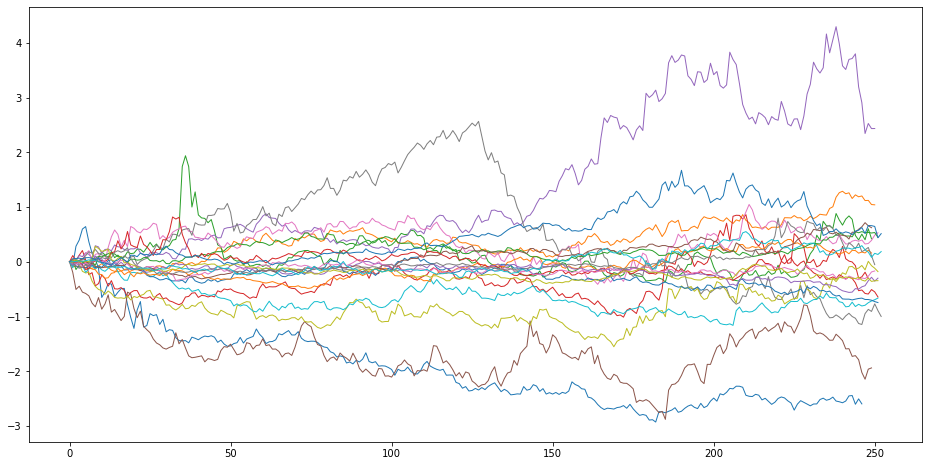

In [48]:
natural_gas_plot = natural_gas_years.plot(figsize=(16,8), legend=False, linewidth=1)

Obtenemos las matrices X e y. La matriz X tiene como columnas la variable año actual y la variable dia actual. La matriz y tiene los precios correspondientes a cada fila de X.

In [49]:
def quarter(day):
    if day <= 61:
        return 0
    elif day > 61 and day <= 61 * 2:
        return 1
    elif day > 61 * 2 and day <= 61 * 3:
        return 2
    else:
        return 3

In [127]:
days = natural_gas_years.index.values
years = [int(year) for year in natural_gas_years.columns.values]

X = pd.DataFrame(columns=['year', 'quarter', 'day', 'y-1'])
y, i, n = np.array([None] * len(years) * len(days)), 0, 0
for year in years:
    for day in days:
        X.loc[i, 'year'], X.loc[i, 'quarter'], X.loc[i, 'day'] = year, quarter(day), day
        if year > years[0]:
            X.loc[i, 'y-1'] = y[n]
            n += 1
        y[i] = natural_gas_years[str(year)].values[day]
        i += 1

mask = ~np.isnan(list(y)) & ~np.isnan(list(X['y-1'].values))
X = X.loc[mask,:].reset_index(drop=True)
y = y[mask]

Iteramos entrenando un GP con kernel rbf sobre los años anteriores a n y el primer trimeste de n, y predecimos el resto del año n para n entre 2016 y 2021.

Predicting year 2011 with data from 2003 to 2010
Elapsed time: 58.380s
Log-marginal-likelihood: -850.666
Predicting year 2012 with data from 2004 to 2011
Elapsed time: 86.297s
Log-marginal-likelihood: -640.123
Predicting year 2013 with data from 2005 to 2012
Elapsed time: 79.388s
Log-marginal-likelihood: -262.494
Predicting year 2014 with data from 2006 to 2013
Elapsed time: 82.415s
Log-marginal-likelihood: -154.443
Predicting year 2015 with data from 2007 to 2014
Elapsed time: 55.706s
Log-marginal-likelihood: -246.459
Predicting year 2016 with data from 2008 to 2015
Elapsed time: 60.788s
Log-marginal-likelihood: -112.005
Predicting year 2017 with data from 2009 to 2016
Elapsed time: 72.733s
Log-marginal-likelihood: -452.514
Predicting year 2018 with data from 2010 to 2017
Elapsed time: 40.983s
Log-marginal-likelihood: -903.608
Predicting year 2019 with data from 2011 to 2018
Elapsed time: 42.839s
Log-marginal-likelihood: -1370.539
Predicting year 2020 with data from 2012 to 2019
Elaps

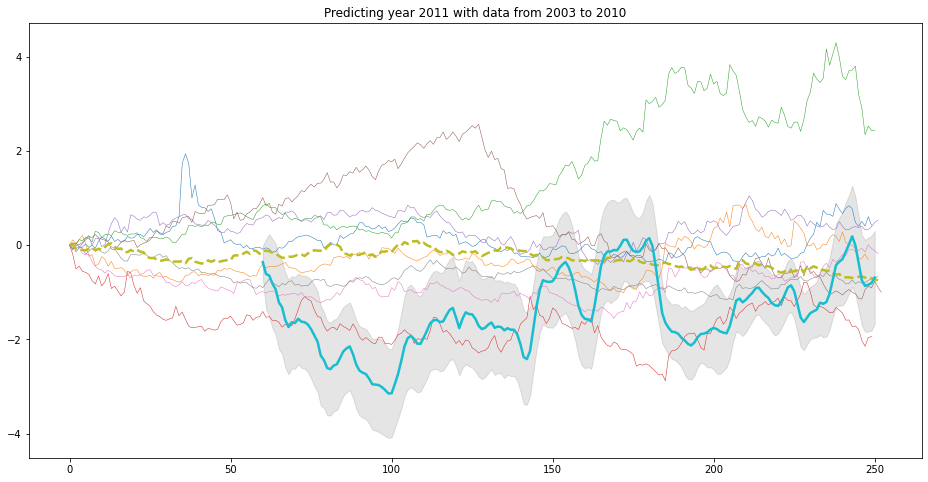

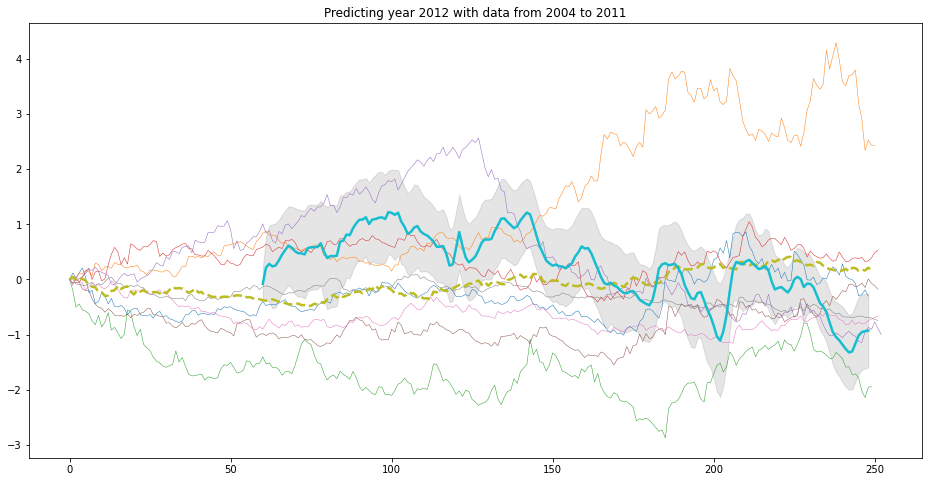

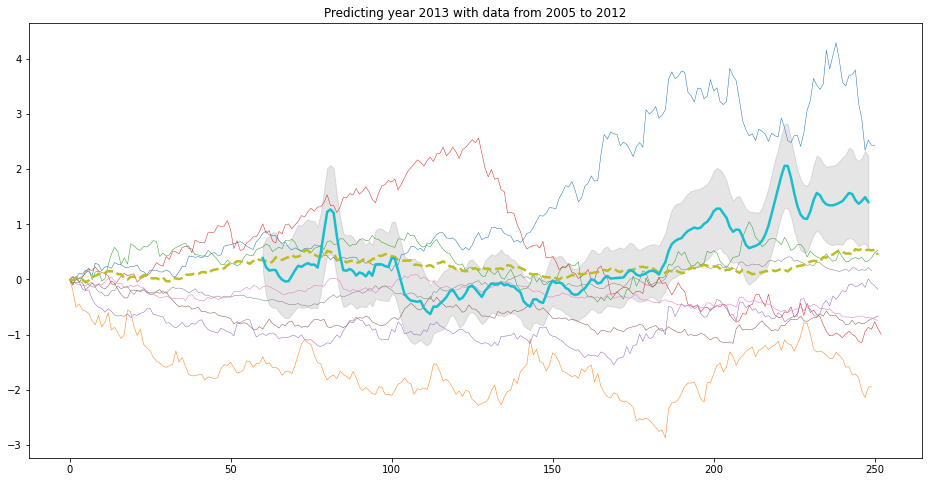

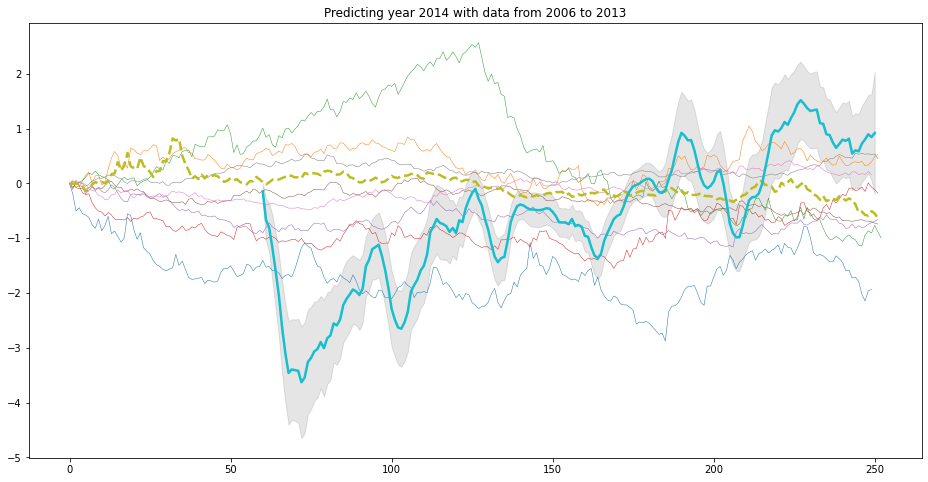

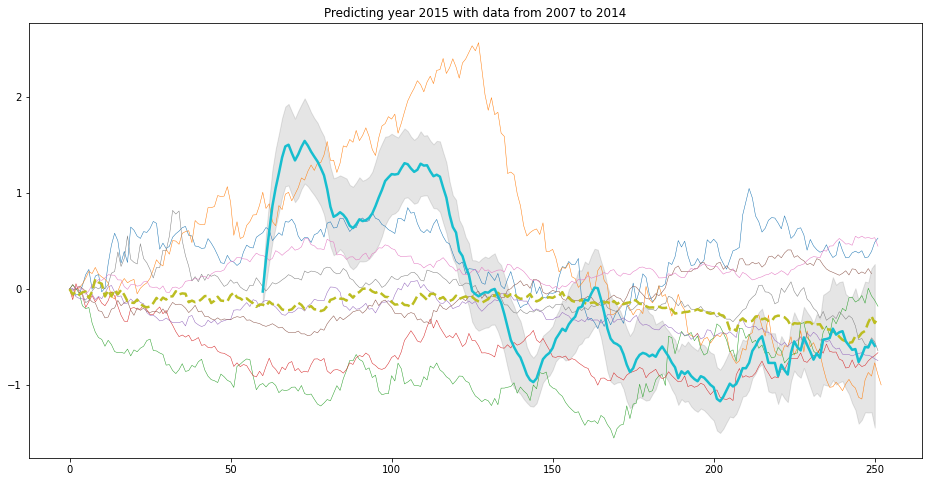

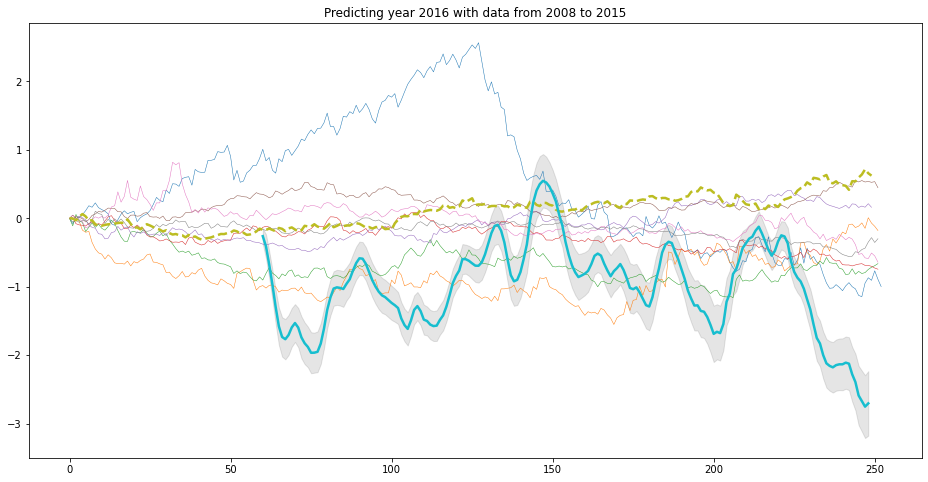

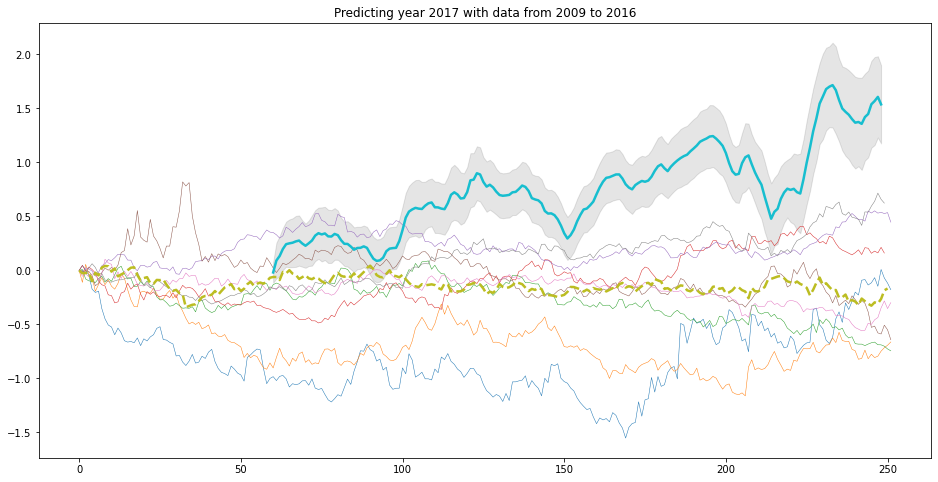

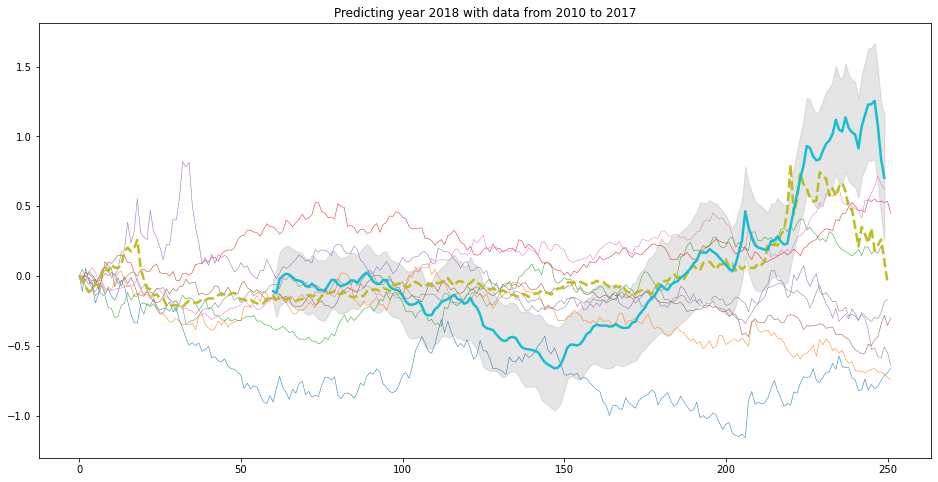

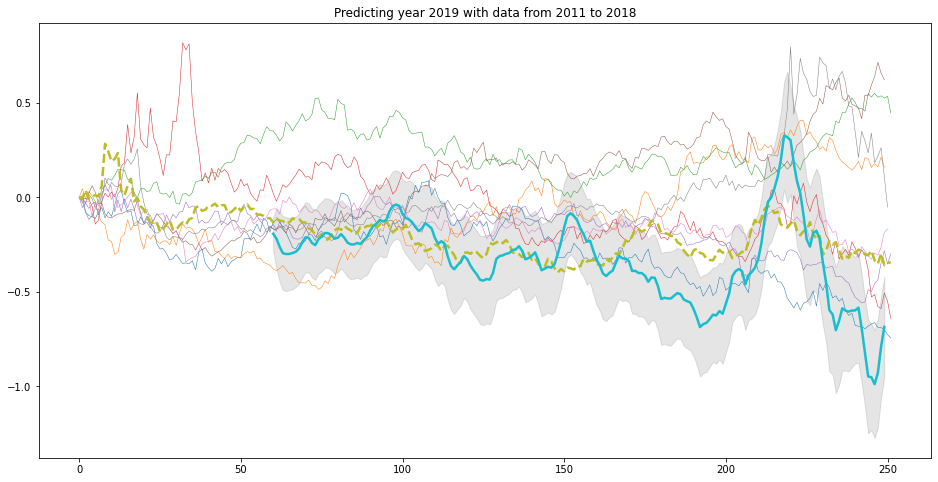

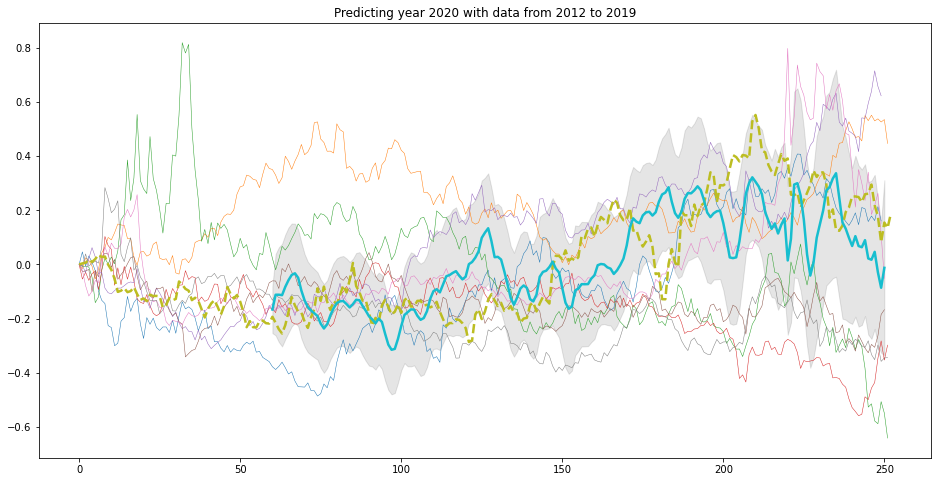

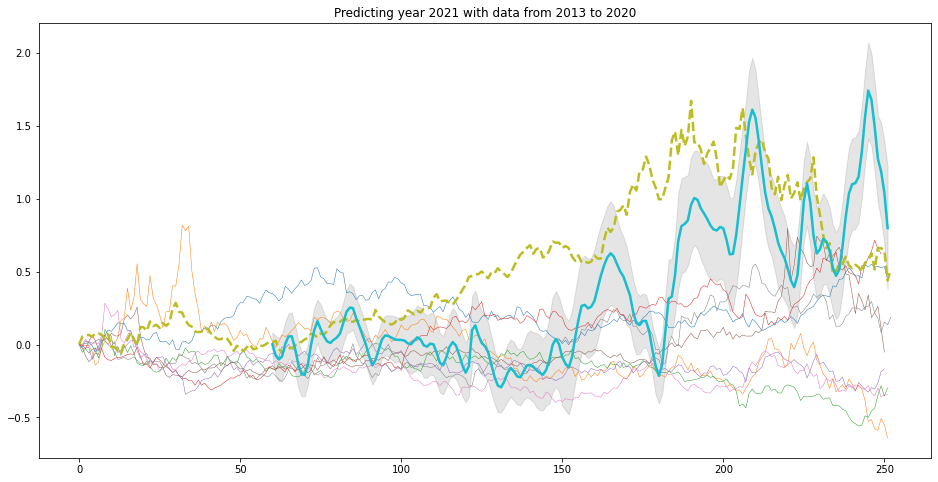

In [140]:
years_pred, days_pred, n_years = range(2011, 2022), 60, 8
for year_pred in years_pred:
    
    title = 'Predicting year {} with data from {} to {}'.format(year_pred, year_pred - n_years, year_pred - 1)
    print(title)
    
    X_train = X.loc[((X['year'] >= year_pred - n_years) & (X['year'] < year_pred)) | ((X['year'] == year_pred) & (X['day'] <= days_pred))]
    y_train = y[X_train.index]
    
    X_test = X.loc[(X['year'] == year_pred) & (X['day'] > days_pred)]
    y_test = y[X_test.index]
    
    kernel = ConstantKernel() * RationalQuadratic() + ConstantKernel() * WhiteKernel()
    gp = GaussianProcessRegressor(kernel=kernel,
                                  normalize_y=True,
                                  n_restarts_optimizer=1,
                                  random_state=2)
    t0 = time()
    gp.fit(X_train, y_train)
    print("Elapsed time: %0.3fs" % (time() - t0))
    print("Log-marginal-likelihood: %.3f" % gp.log_marginal_likelihood(gp.kernel_.theta))
    
    y_pred, y_std = gp.predict(X_test, return_std=True)
    
    hco = natural_gas_years.loc[:,'{}-01-01'.format(year_pred - n_years - 1):'{}-01-01'.format(year_pred - 1)].plot(figsize=(16,8), legend=False, linewidth=.5, title=title)
    p = hco.plot(natural_gas_years[str(year_pred)], linewidth=2.5, linestyle='--')
    y_plot, y_plot[days_pred:] = [None] * (len(y_pred) + days_pred), y_pred
    p = hco.plot(y_plot, linewidth=2.5)
    p = hco.fill_between(range(days_pred, len(y_pred) + days_pred), y_pred - y_std, y_pred + y_std, alpha=0.1, color='k')
    f = hco.get_figure()
    f.savefig('Figures/{}.png'.format(year_pred))